# Preprocessed ML Integrated Dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
df = pd.read_csv("infolimpioavanzadoTarget.csv")


In [75]:
df["ticker"].unique()


array(['ASLE', 'ATHE', 'ASMB', 'ASTR', 'ATIF', 'ASO', 'ATCOL', 'ASTE',
       'ASYS', 'ATLC', 'ASRV', 'ATER', 'ATHA', 'ASLN', 'ATLO', 'ASPAU',
       'ASML', 'ASPS', 'ASND', 'ATEX', 'ASRT', 'ATLCP', 'ATAI', 'ASTL',
       'ATLCL', 'ASPA', 'ASUR', 'ASTS', 'ASTC', 'ATEC', 'ATHX'],
      dtype=object)

In [76]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

/tmp/ipython-input-2393446622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


In [ ]:
df["target"] = df["adjclose"].shift(-1)

In [77]:
df = df[df["ticker"] == "ASML"].reset_index(drop=True)


In [78]:
df = df[df["ticker"] == "ASML"].reset_index(drop=True)


In [79]:
print("Rows for ASML:", len(df))


Rows for ASML: 251


In [82]:
df = df[df["adjclose"] != 0]
df["target"] = (df["adjclose"].shift(-1) - df["adjclose"]) / df["adjclose"]
df = df.dropna(subset=["target"]).reset_index(drop=True)


In [83]:
features = [
    "adjclose",
    "open", "high", "low",
    "volume", "lagvolume1",

    "smaadjclose5", "smaadjclose50",
    "emaadjclose5", "emaadjclose15", "emaadjclose50",

    "RSIadjclose15", "RSIadjclose25", "RSIadjclose50",
    "RSIvolume15", "RSIvolume25", "RSIvolume50"
]

In [84]:
X = df[features]
y = df["target"]

In [85]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.ffill().bfill()

In [86]:
print("Final rows after cleaning:", len(X))


Final rows after cleaning: 250


In [87]:
clean = pd.concat([X, y], axis=1).dropna()


In [88]:
X = clean[features]
y = clean["target"]

In [89]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

In [91]:
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 200
Test size: 50


# Random Forest Regressor

In [92]:

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=400,
                      n_jobs=-1, random_state=42)

In [93]:
y_pred = model.predict(X_test)


In [94]:
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denom
    diff = diff[~np.isnan(diff)]
    return np.mean(diff) * 100

In [99]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

metrics_table = pd.DataFrame({
    "Metric": ["RMSE (return)", "MAE (return)", "R²"],
    "Value":  [rmse, mae, r2]
})

print(metrics_table)

          Metric     Value
0  RMSE (return)  0.034848
1   MAE (return)  0.025110
2             R² -0.041281


# HistGradientBoosting

In [101]:
from sklearn.ensemble import HistGradientBoostingRegressor


In [102]:
model_hgb = HistGradientBoostingRegressor(
    max_depth=8,
    learning_rate=0.05,
    max_iter=500,
    l2_regularization=0.0,
    random_state=42
)

model_hgb.fit(X_train, y_train)

HistGradientBoostingRegressor(learning_rate=0.05, max_depth=8, max_iter=500,
                              random_state=42)

In [103]:
y_pred_hgb = model_hgb.predict(X_test)


In [109]:
main_cols = ["open", "high", "low", "close", "adjclose", "volume"]

corr = df[main_cols].corr()
print("\nCorrelation between main columns:")
print(corr)


Correlation between main columns:
              open      high       low     close  adjclose    volume
open      1.000000  0.995879  0.995734  0.987423  0.986599 -0.114050
high      0.995879  1.000000  0.996184  0.995060  0.994049 -0.080974
low       0.995734  0.996184  1.000000  0.994913  0.994568 -0.130903
close     0.987423  0.995060  0.994913  1.000000  0.999647 -0.086656
adjclose  0.986599  0.994049  0.994568  0.999647  1.000000 -0.090754
volume   -0.114050 -0.080974 -0.130903 -0.086656 -0.090754  1.000000


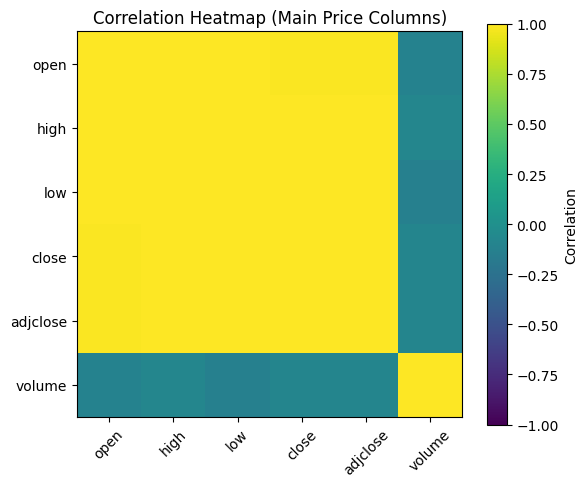

In [110]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 5))
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(label="Correlation")
plt.xticks(range(len(main_cols)), main_cols, rotation=45)
plt.yticks(range(len(main_cols)), main_cols)
plt.title("Correlation Heatmap (Main Price Columns)")
plt.tight_layout()
plt.show()

In [113]:
df["return_pct"] = df["adjclose"].pct_change() * 100


In [114]:
returns = df["return_pct"].dropna()


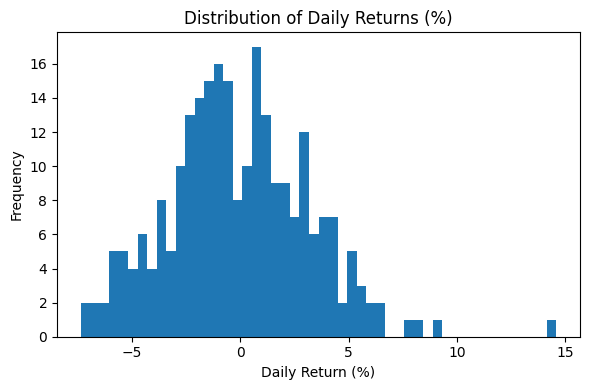

In [115]:
plt.figure(figsize=(6, 4))
plt.hist(returns, bins=50)
plt.title("Distribution of Daily Returns (%)")
plt.xlabel("Daily Return (%)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

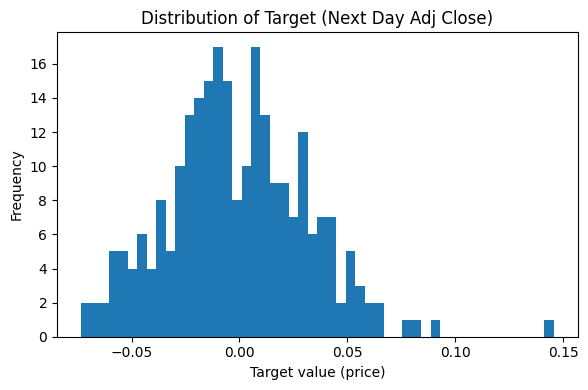

In [116]:
plt.figure(figsize=(6, 4))
plt.hist(df["target"], bins=50)
plt.title("Distribution of Target (Next Day Adj Close)")
plt.xlabel("Target value (price)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()